In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchsummary import summary

print(torch.__version__)

1.11.0+cu113


In [2]:
# Hyper-parameters
learning_rate = 0.0001
n_epochs = 5
batch_size = 100
n_classes = 10
random_seed = 777

In [3]:
# For Reproducibilty
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
# Data 불러오기
data_dir = './data'

train_data = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.Compose([transforms.Resize((224,224)), 
                                  transforms.ToTensor()])
)

val_data = datasets.CIFAR10(
    root=data_dir,
    train=False,
    download=True,
    transform=transforms.Compose([transforms.Resize((224,224)), 
                                  transforms.ToTensor()])
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [6]:
val_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [7]:
label_list = train_data.classes
label_list

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

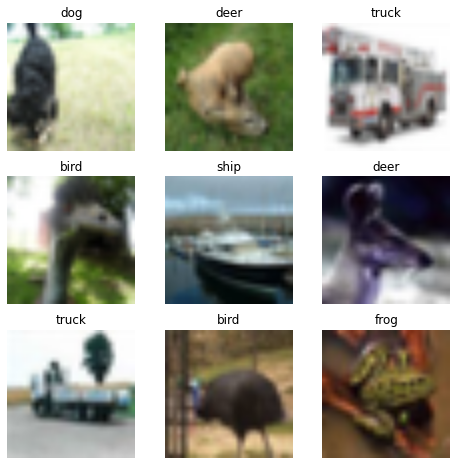

In [8]:
# Data Visualization
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    img = img.permute(1,2,0)
    figure.add_subplot(rows, cols, i)
    plt.title(label_list[label])
    plt.axis("off")
    plt.imshow(img)
plt.show()

In [9]:
# DataLoader 만들기
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

Feature batch shape: torch.Size([100, 3, 224, 224])
Labels batch shape: torch.Size([100])


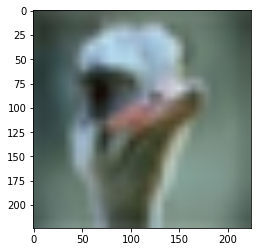

Label: bird(2)


In [10]:
# DataLoader를 통해 반복하기(iterate)
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].permute(1,2,0)
label = train_labels[0]
label_name = label_list[label]
plt.imshow(img)
plt.show()
print(f"Label: {label_name}({label})")

In [11]:
# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [12]:
class Conv_Block(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super(Conv_Block, self).__init__()
    self.conv_bn_relu = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU())
  
  def forward(self, x):
    return self.conv_bn_relu(x)

In [13]:
class Inception_Block(nn.Module):
  def __init__(self, in_channels, out_1x1, reduce_3x3, out_3x3, reduce_5x5, out_5x5, pool_proj):
    super(Inception_Block, self).__init__()
    self.branch1 = nn.Sequential(Conv_Block(in_channels, out_1x1, 1, 1, 0))
    self.branch2 = nn.Sequential(Conv_Block(in_channels, reduce_3x3, 1, 1, 0),
                                 Conv_Block(reduce_3x3, out_3x3, 3, 1, 1))
    self.branch3 = nn.Sequential(Conv_Block(in_channels, reduce_5x5, 1, 1, 0),
                                 Conv_Block(reduce_5x5, out_5x5, 5, 1, 2))
    self.branch4 = nn.Sequential(nn.MaxPool2d(3, 1, 1),
                                 Conv_Block(in_channels, pool_proj, 1, 1, 0))
  
  def forward(self, x):
    x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
    return x

In [14]:
class GoogLeNet(nn.Module):
  def __init__(self):
    super(GoogLeNet, self).__init__()
    self.stem = nn.Sequential(Conv_Block(3, 64, 7, 2, 3),
                              nn.MaxPool2d(3, 2, 1),
                              Conv_Block(64, 64, 1, 1, 0),
                              Conv_Block(64, 192, 3, 1, 1),
                              nn.MaxPool2d(3, 2, 1))
    self.inception3a = Inception_Block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_Block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(3, 2, 1)
    self.inception4a = Inception_Block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_Block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_Block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_Block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_Block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(3, 2, 1)
    self.inception5a = Inception_Block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_Block(832, 384, 192, 384, 48, 128, 128)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.dropout = nn.Dropout(0.4)
    self.fc = nn.Linear(1024, n_classes)
  
  def forward(self, x):
    x = self.stem(x)
    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)
    x = self.inception4a(x)
    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)
    x = x.view(-1, 1024)
    x = self.dropout(x)
    x = self.fc(x)
    return x

In [15]:
model = GoogLeNet().to(device)

In [16]:
print(model)

GoogLeNet(
  (stem): Sequential(
    (0): Conv_Block(
      (conv_bn_relu): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): Conv_Block(
      (conv_bn_relu): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): Conv_Block(
      (conv_bn_relu): Sequential(
        (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (inception3a): Inception_

In [17]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
        Conv_Block-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
        Conv_Block-9           [-1, 64, 56, 56]               0
           Conv2d-10          [-1, 192, 56, 56]         110,784
      BatchNorm2d-11          [-1, 192, 56, 56]             384
             ReLU-12          [-1, 192, 56, 56]               0
       Conv_Block-13          [-1, 192, 56, 56]               0
        MaxPool2d-14          [-1, 192,

In [18]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()

In [19]:
# Optimizer
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

In [20]:
# Train Function
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  n_batches = len(dataloader)
  model.train()
  train_loss = 0.
  for batch, (data, label) in enumerate(dataloader):
    data, label = data.to(device), label.to(device)
    pred = model(data)
    loss = loss_fn(pred, label)    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  train_loss /= n_batches

  print(f"Training Loss: {train_loss:>8f}")

In [21]:
# Validation Function
def val_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  n_batches = len(dataloader)
  model.eval()
  val_loss, correct = 0., 0
  with torch.no_grad():
    for data, label in dataloader:
      data, label = data.to(device), label.to(device)
      pred = model(data)
      val_loss += loss_fn(pred, label).item()
      correct += (pred.argmax(1) == label).type(torch.float).sum().item()
  val_loss /= n_batches
  correct /= size
  print(f"Validation Loss: {val_loss:>8f} Validation Accuracy: {(100*correct):>0.4f}%, \n")

In [22]:
# 학습 진행하기
for epoch in range(n_epochs):
  print(f"<<Epoch {epoch+1}>>\n------------------------------------------------")
  train_loop(train_dataloader, model, loss_fn, optimizer)
  val_loop(val_dataloader, model, loss_fn)
print("Training Done!")

<<Epoch 1>>
------------------------------------------------
Training Loss: 1.284755
Validation Loss: 1.144053 Validation Accuracy: 58.3000%, 

<<Epoch 2>>
------------------------------------------------
Training Loss: 0.826863
Validation Loss: 0.780092 Validation Accuracy: 71.9900%, 

<<Epoch 3>>
------------------------------------------------
Training Loss: 0.608194
Validation Loss: 0.734525 Validation Accuracy: 74.8500%, 

<<Epoch 4>>
------------------------------------------------
Training Loss: 0.460607
Validation Loss: 0.761824 Validation Accuracy: 74.8400%, 

<<Epoch 5>>
------------------------------------------------
Training Loss: 0.352766
Validation Loss: 0.588858 Validation Accuracy: 80.2500%, 

Training Done!
